Author: rei-ashine<br>
DATE: Oct. 19th, 2023<br>
Script for Visualizing PISA scores<br>

---

In [1]:
import os
import sys
import os.path
import warnings
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
print("Python " + sys.version)
print("Seaborn " + sns.__version__)

Python 3.9.16 (main, May 16 2023, 14:27:50) 
[Clang 14.0.6 ]
Seaborn 0.12.2


---

In [3]:
# Set input file path 
#path_input = "../data/GoogleSheets/Mutate_7e5o_GlobalMinimized_H-TYR_104.csv"
path_input = "../data/GoogleSheets/Mutate_7e5o_GlobalMinimized_H-TYR_104_MET_and_then_H-SER_56.csv"
#path_input = "../data/GoogleSheets/Mutate_7e5o_GlobalMinimized_H-TYR_104_MET_and_H-SER_56_CYS_and_H-TYR_33.csv"
#path_input = "../data/GoogleSheets/Mutate_7e5o_GlobalMinimized_L-PHE_94.csv"
#path_input = "../data/GoogleSheets/Mutate_7e5o_GlobalMinimized_L-SER_68.csv"

# Set output directory path
path_output = "../data/PISA"

---

In [4]:
def loader(path):
    """
    Load the PISA score CSV file.
    """
    data = pd.read_csv(path)
    
    basename = os.path.basename(path)
    filename = os.path.splitext(basename)[0]
    print("[INFO] Input CSV file : ", basename)
    
    return data, filename

In [5]:
df, filename = loader(path_input)
df.head(10)

[INFO] Input CSV file :  Mutate_7e5o_GlobalMinimized_H-TYR_104_MET_and_then_H-SER_56.csv


,Mutations,Interfacing\nstructures,Nocc,Diss.,Sym.ID,Buried area\n[Å2],ΔiG\n[kcal/mol],NHB,NSB,NDS,CSS
0,7E5O,A + H,1,×,1_555,498.3,0.9,11,1,0,0.011
1,GlobalMinimized,A + D,1,×,1_555,509.3,-1.6,8,2,0,0.000
2,SingleMutation,A + D,1,NaN,1_555,533.6,-3.3,10,2,0,0.000
3,DoubleMutation,A + D,1,NaN,1_555,506.4,-4.9,9,2,0,0.000
4,p.Ser56Ala,A + D,1,NaN,1_555,527.2,-3.1,10,3,0,0.000
5,p.Ser56Arg,A + D,1,×,1_555,586.6,0.6,11,8,0,0.000
6,p.Ser56Asn,A + D,1,NaN,1_555,552.3,-3.1,12,3,0,0.000
7,p.Ser56Asp,A + D,1,NaN,1_555,518.7,-2.6,11,3,0,0.000
8,p.Ser56Cys,A + D,1,NaN,1_555,534.6,-4.9,11,3,0,0.000
9,p.Ser56Gln,A + D,1,NaN,1_555,536.3,-3.4,8,3,0,0.000


---

In [6]:
def init_figure():
    """
    Initialize the figure.
    """
    # Figure
    sns.set(font_scale=6)
    sns.set_palette("Set1")
    sns.set_style("whitegrid")
    
    fig = plt.figure(figsize=(50, 25))
    plt.subplots_adjust(left=0.02, bottom=0.06, right=0.8, top=0.96)
    ax = plt.gca()    # <-- To avoid MatplotlibDeprecationWarning
    
    # Font
    theme_font = "Times New Roman"
    plt.rcParams["font.family"] = theme_font
    
    # math font
    plt.rcParams["mathtext.fontset"] = "stix"
    plt.rcParams["font.size"] = 20
    
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    
    return fig, ax

In [7]:
def label_point(x, y, id, ax):
    """
    Label each point in a scatterplot.
    """
    df_tmp = pd.concat({"x":x, "y":y, "id":id}, axis="columns")
    for i, point in df_tmp.iterrows():
        ax.text(point["x"], point["y"]-0.1, point["id"],
                fontsize=50, horizontalalignment="center", rotation=25)

In [8]:
def scatterplot(data, filename, group, path):
    """
    Make a scatter plot.
    """
    # Initialize a figure
    fig, ax = init_figure()
    theme_font = "Times New Roman"
    
    xlabel = "Buried area\n[Å2]"
    ylabel = "ΔiG\n[kcal/mol]"
    idx = "Mutations"
    
    # Make a scatterplot
    ax = sns.scatterplot(data, x=xlabel, y=ylabel,
                         hue=group, size=group, sizes=(1000, 10000), 
                         legend="full", palette="viridis")
    # Set labels
    label_point(data[xlabel], data[ylabel], data[idx], ax)

    # Set legends
    if group == "NHB":
        legend_title = "Number of potential \nHydrogen bonds"
    elif group == "NSB":
        legend_title = "Number of potential \nSalt bridges"
    else:
        legend_title = group
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1.035),
                    fontsize=80, title_fontsize=60, title=legend_title)
    
    # Set the title of this figure
    position = re.findall("Mutate_7e5o_GlobalMinimized_(.*)", filename)
    position = re.findall("([H,L]\-[A-Z]{3}_[0-9]+_[A-Z]{3}|[H,L]\-[A-Z]{3}_[0-9]+)", position[0])
    for i, p in enumerate(position):
        # Check the chain name
        if "H-" in p:
            chain = " in Heavy chain"
        elif "L-" in p:
            chain = " in Light chain"
        else:
            assert (re.match("[H,L]\-", p)), \
                "[Warning] An unknown file naming convention was detected."
        # Convert to protein mutation notation
        tmp = re.sub("[H,L]\-", "", p)
        tmp = tmp.split("_")
        tmp = list(map(lambda x: x.capitalize(), tmp))
        position[i] = "p." + "".join(tmp)
    
    position = "[ " + ", ".join(position) + " ]"
    
    fig_title = "Mutation of antibody residues at \n" + position + chain
    ax.set_title(fig_title, loc="left", fontsize=100, pad=100, fontname=theme_font)
    
    # Set axis names and axis labels
    ax.set_xlabel(xlabel.replace("\n", " "), labelpad=30, fontname=theme_font)
    ax.set_ylabel(ylabel.replace("\n", " "), labelpad=30, fontname=theme_font)
    plt.xticks(fontname=theme_font)
    plt.yticks(fontname=theme_font)
    
    # Make the output directory
    os.makedirs(path) if not os.path.exists(path) else None
    
    # Save figure
    name = filename + "_scatterplot_" + group + ".png" 
    output = path + "/" + name
    
    #fig.tight_layout()
    print("[INFO] Output scatterplot file : ", name)
    
    #fig.savefig(output, dpi=300)
    #fig.savefig(output, transparent=True, dpi=300)
    plt.show()

[INFO] Output scatterplot file :  Mutate_7e5o_GlobalMinimized_H-TYR_104_MET_and_then_H-SER_56_scatterplot_NHB.png


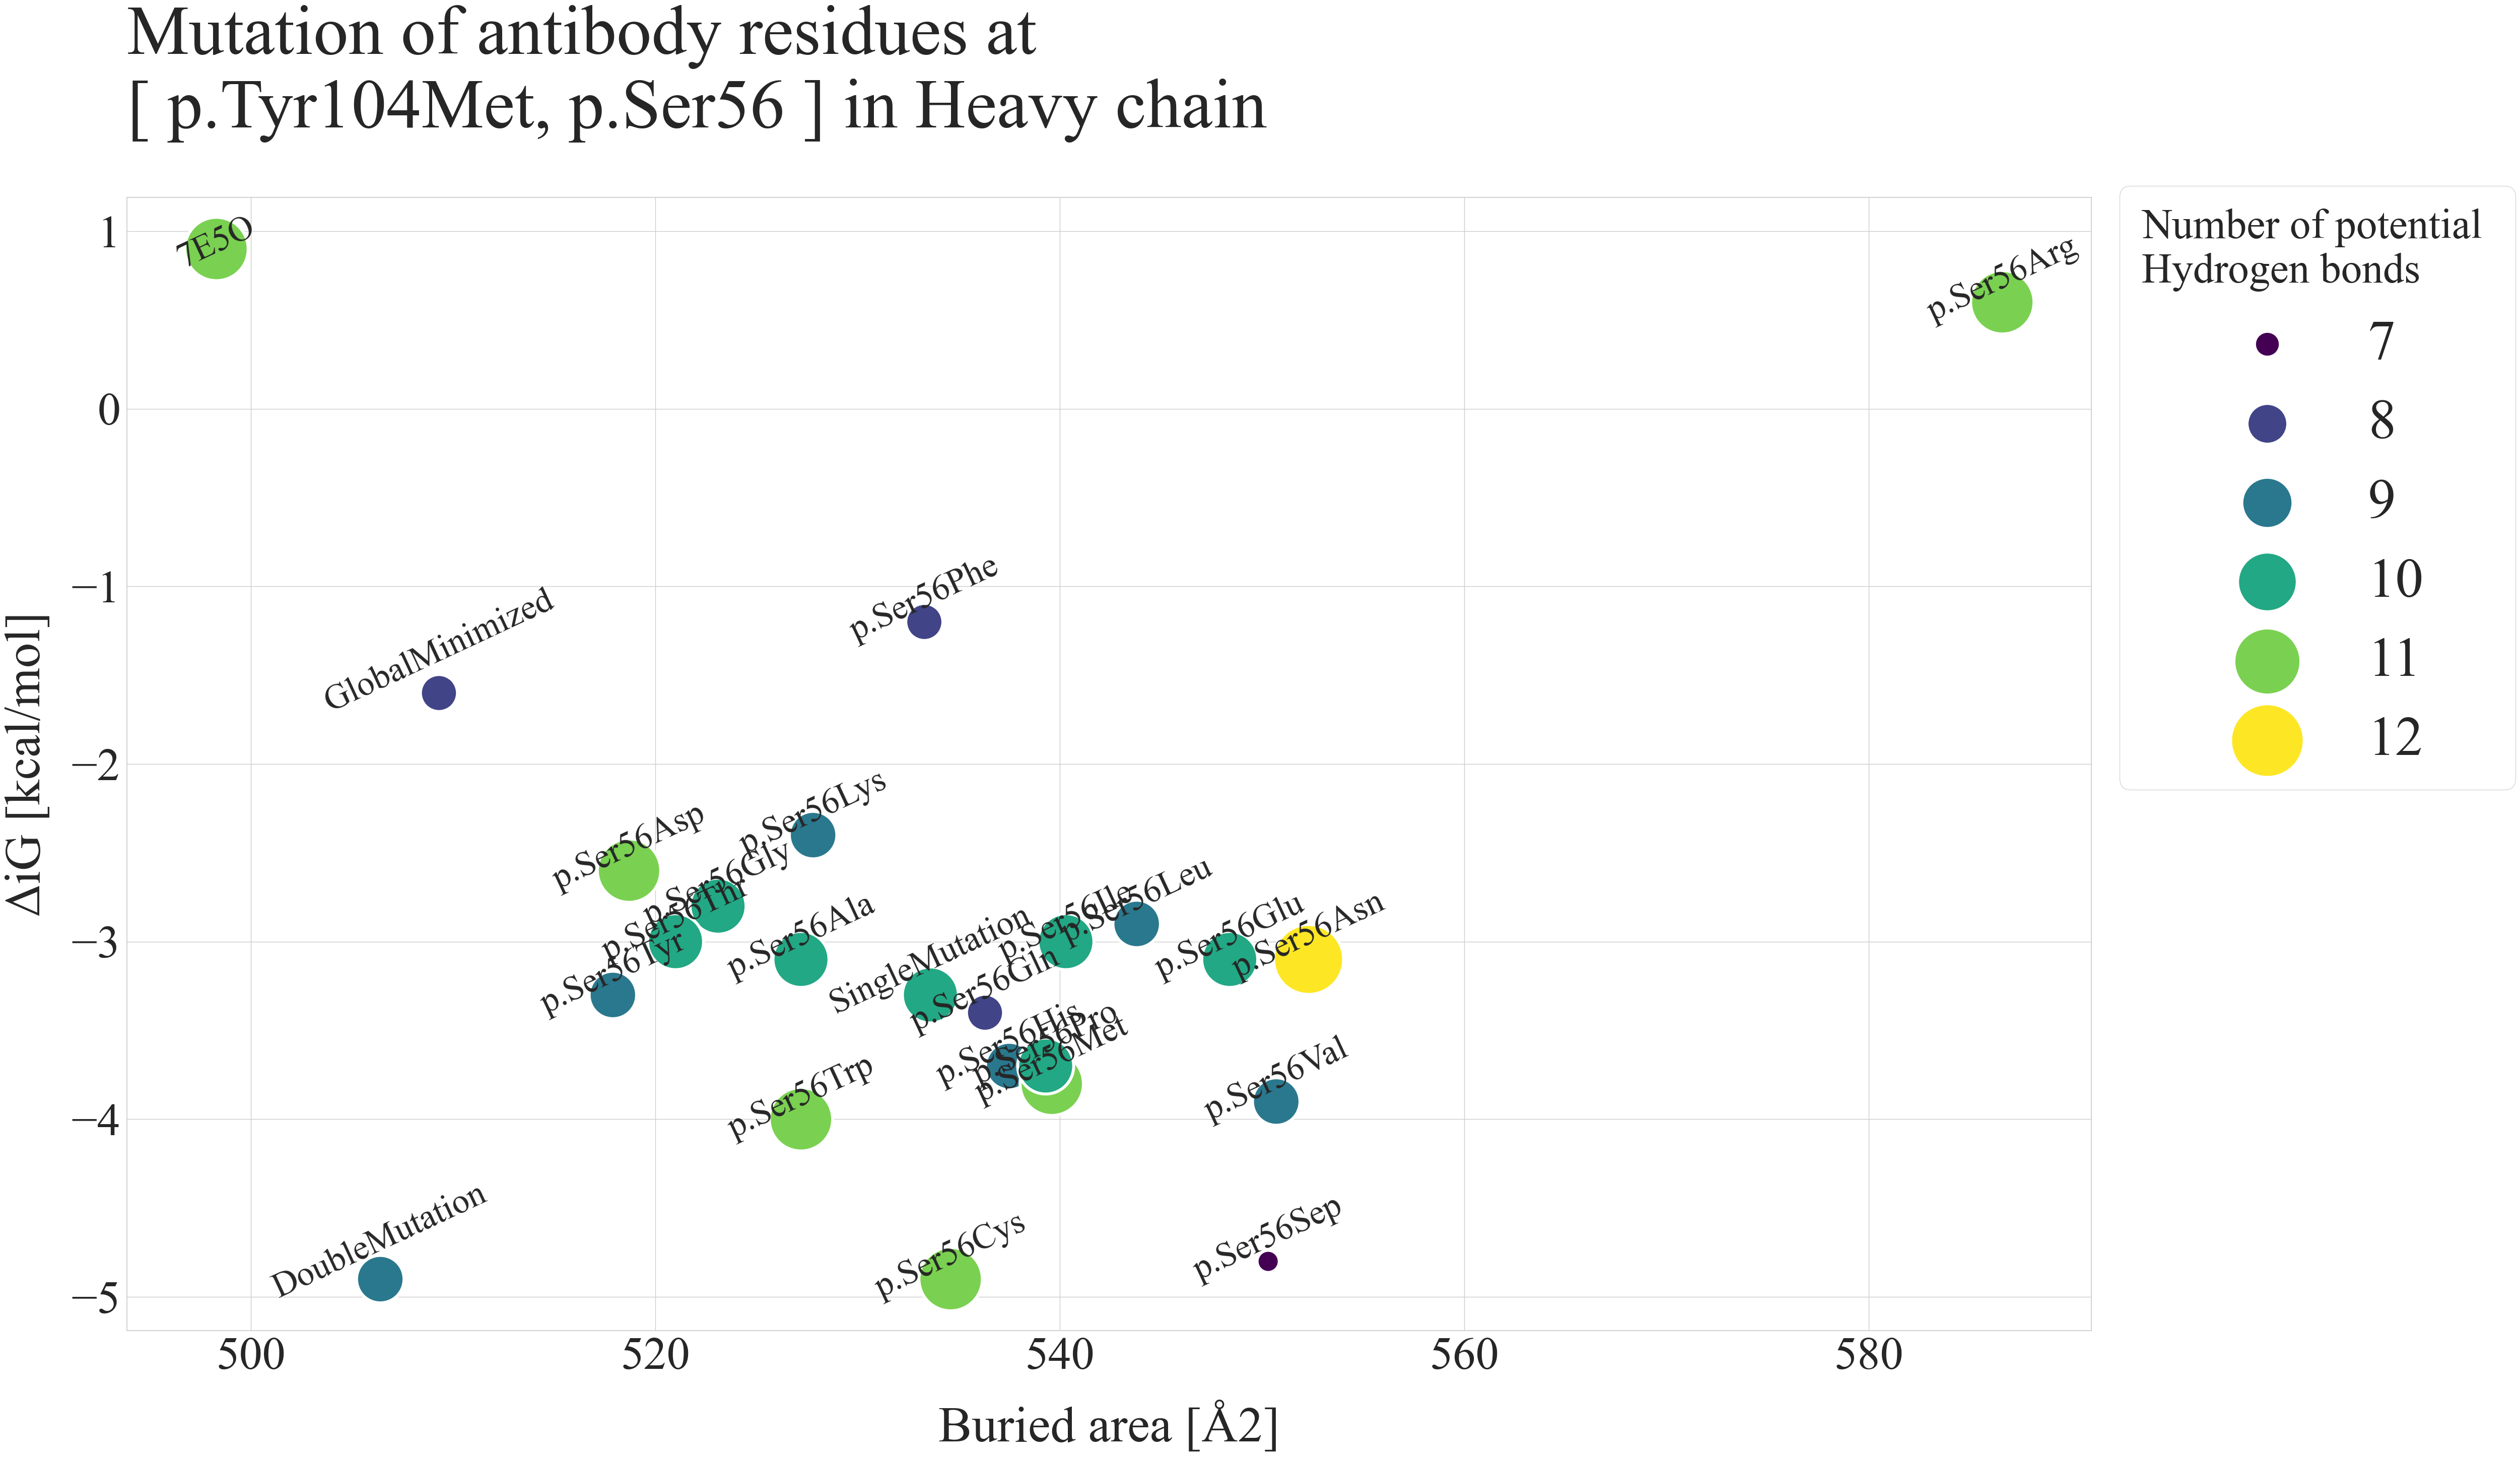

In [9]:
scatterplot(df, filename, "NHB", path_output)

[INFO] Output scatterplot file :  Mutate_7e5o_GlobalMinimized_H-TYR_104_MET_and_then_H-SER_56_scatterplot_NSB.png


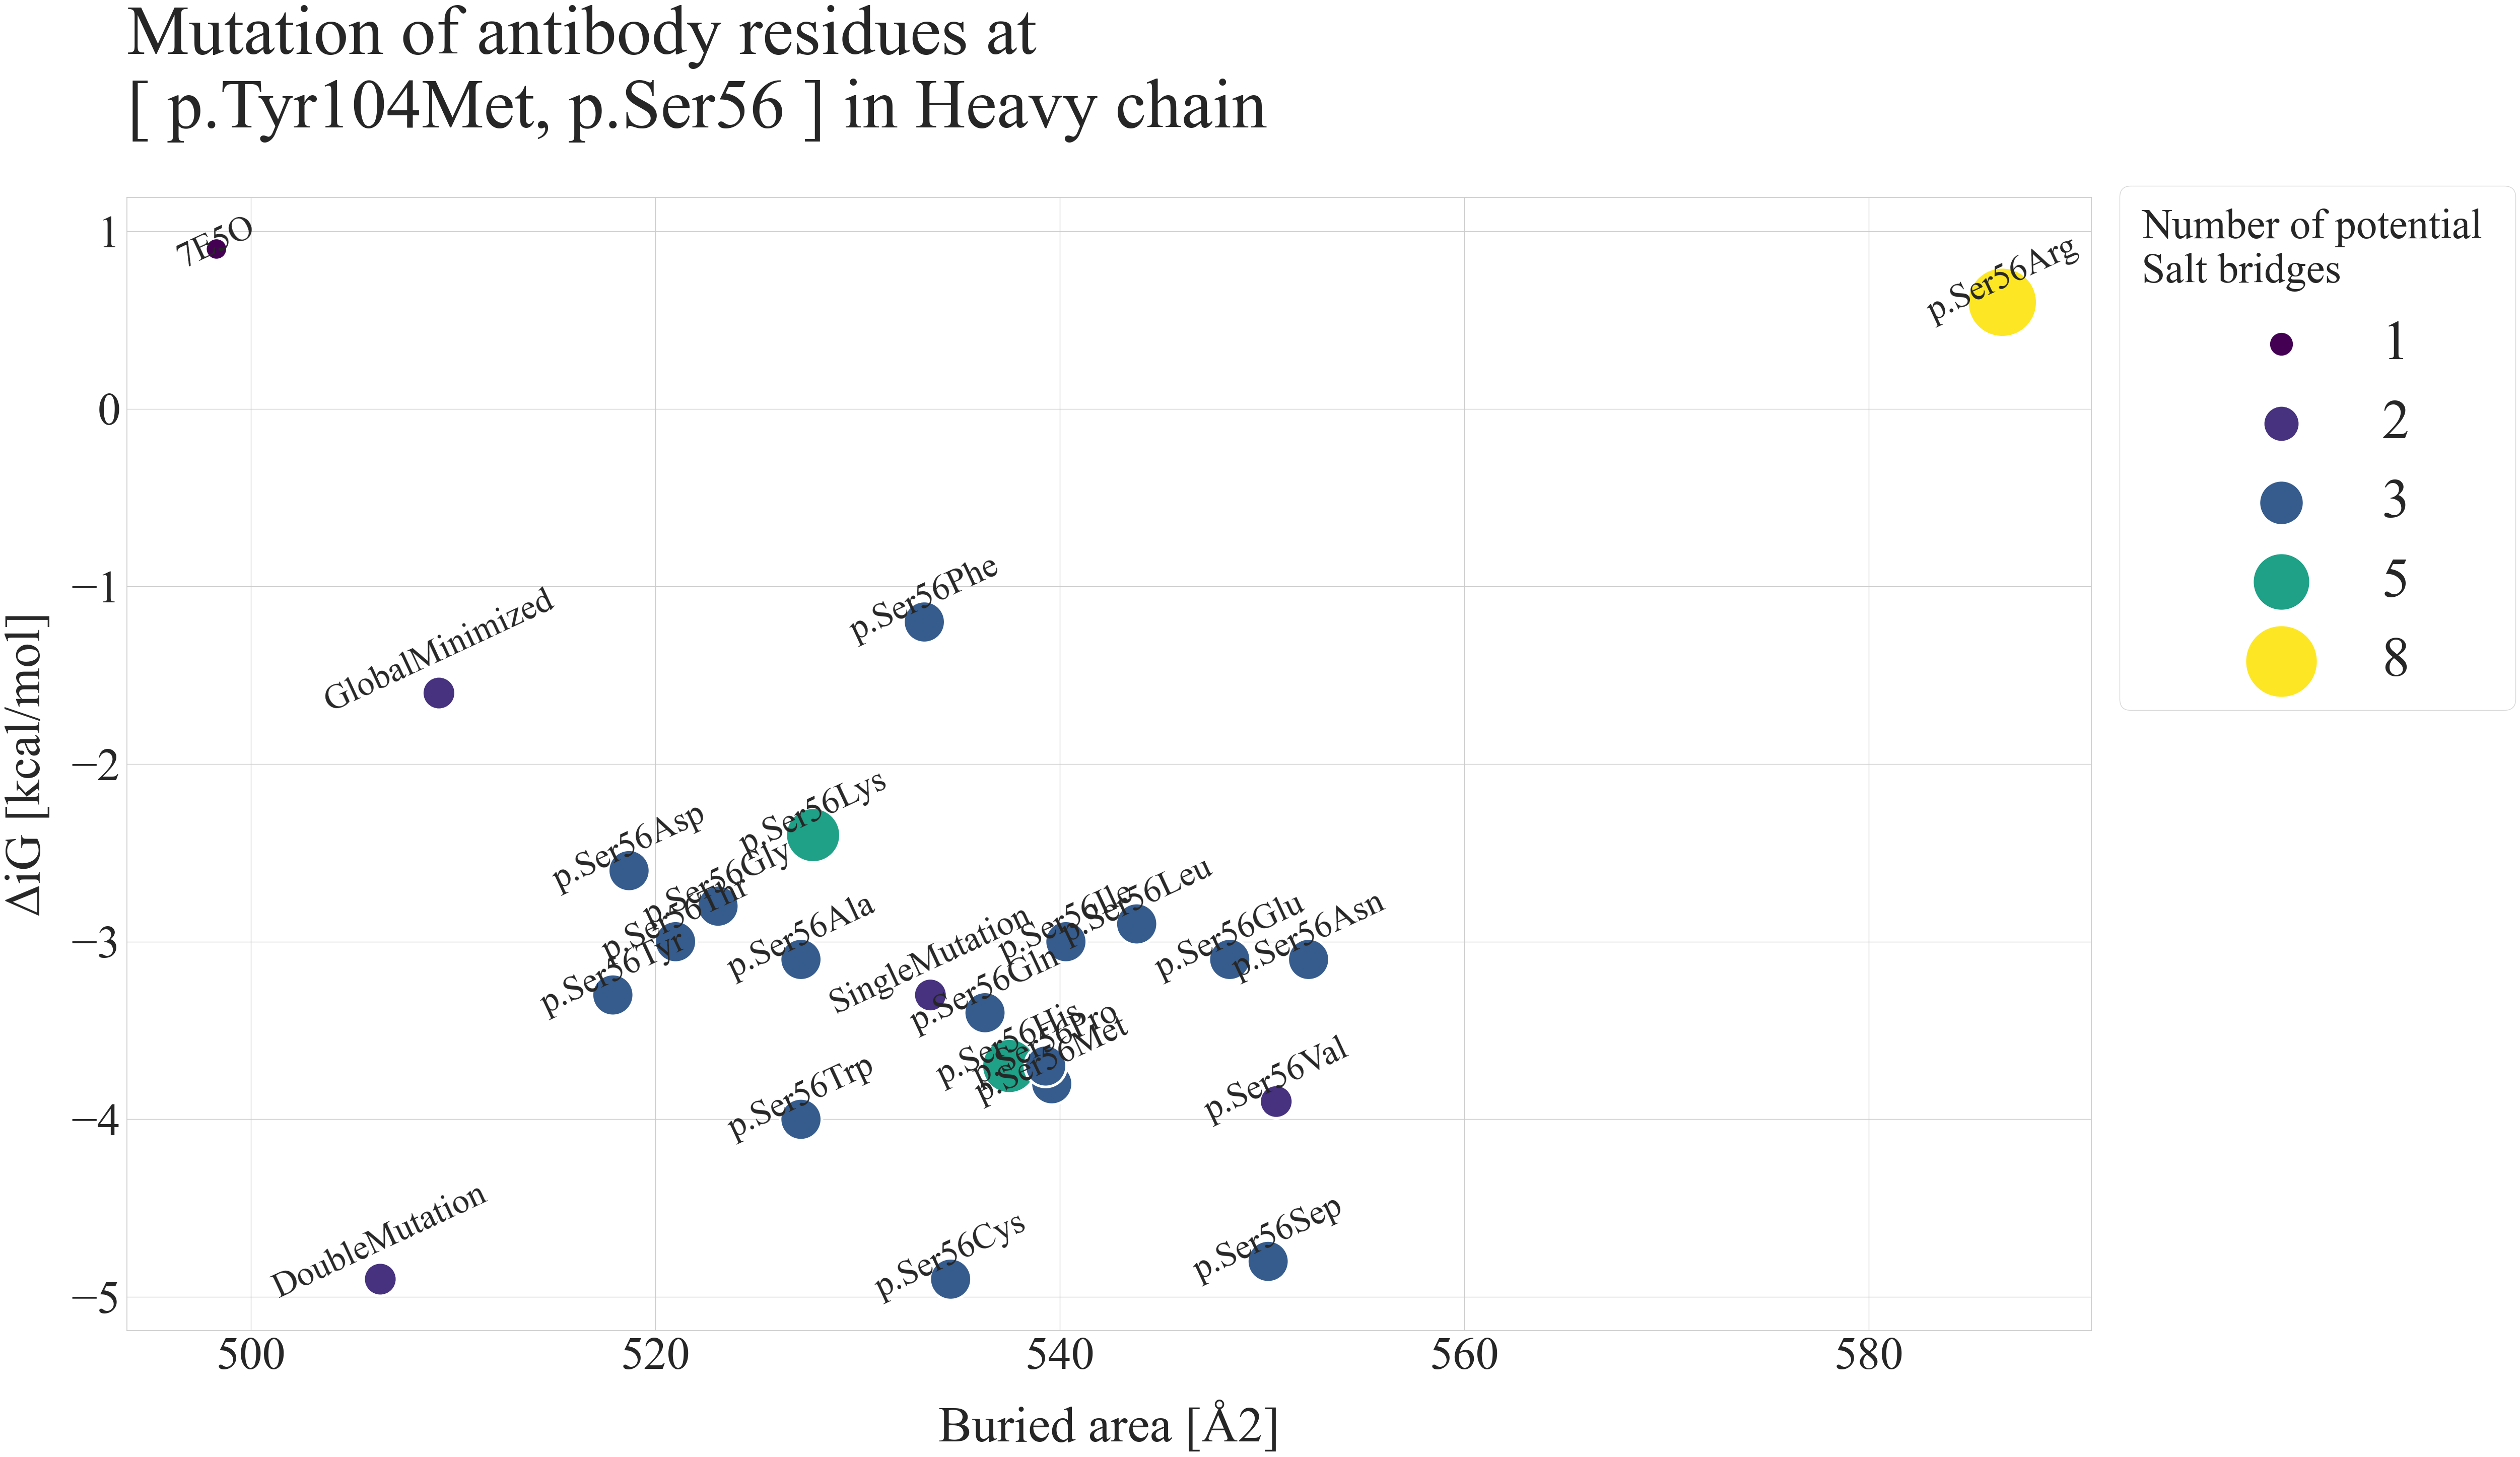

In [10]:
scatterplot(df, filename, "NSB", path_output)